In [44]:
# Importing necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import openpyxl

In [45]:
# Directory setup
gp2_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
output_analysis_dir = os.path.join(gp2_dir, 'Distribution Analysis', 'Output Analysis')
assert output_analysis_dir == os.getcwd(), f"Expected output_analysis_dir to be the current working directory."
figures_dir = os.path.join(gp2_dir, 'Report', 'Figures', 'Distribution Analysis', 'Output Analysis')
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
laptop_timings_xlsx = os.path.join(output_analysis_dir, '300_weeks', 'laptop_timings.xlsx')
improved_timings_xlsx = os.path.join(output_analysis_dir, '300_weeks_improved', 'laptop_timings.xlsx')
assert os.path.exists(laptop_timings_xlsx), f"Expected {laptop_timings_xlsx} to exist."
assert os.path.exists(improved_timings_xlsx), f"Expected {improved_timings_xlsx} to exist."

In [46]:
# Load data from Excel files
laptop_timings_df = pd.read_excel(laptop_timings_xlsx)
improved_timings_df = pd.read_excel(improved_timings_xlsx) 

laptop_timings_df = laptop_timings_df[laptop_timings_df['laptop_num'].apply(lambda x: isinstance(x, int))]
improved_timings_df = improved_timings_df[improved_timings_df['laptop_num'].apply(lambda x: isinstance(x, int))]
laptop_timings_df['laptop_num'] = laptop_timings_df['laptop_num'].astype(int)
improved_timings_df['laptop_num'] = improved_timings_df['laptop_num'].astype(int)
laptop_timings_df = laptop_timings_df[laptop_timings_df['order_num'].apply(lambda x: isinstance(x, int))]
improved_timings_df = improved_timings_df[improved_timings_df['order_num'].apply(lambda x: isinstance(x, int))]
laptop_timings_df['order_num'] = laptop_timings_df['order_num'].astype(int)
improved_timings_df['order_num'] = improved_timings_df['order_num'].astype(int)

orders_df = laptop_timings_df.dropna(subset=['shipped_time']).copy()
orders_df['order_cycle_time'] = orders_df['shipped_time'] - orders_df['arrival_time']
improved_orders_df = improved_timings_df.dropna(subset=['shipped_time']).copy()
improved_orders_df['order_cycle_time'] = improved_orders_df['shipped_time'] - improved_orders_df['arrival_time']

/opt/homebrew/anaconda3/envs/Group_Project_2/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [47]:
def plot_moving_average(df, x, y, title, x_label, y_label, filename):
    """
    Function to plot moving averages of data.
    """
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df,x=x, y=y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(figures_dir, filename))
    plt.close()

def get_moving_average(df, column_name, window_size=10):
    """
    Function to calculate moving average.
    """
    return df[column_name].rolling(window=window_size).mean()

from typing import Optional

def plot_moving_average_cycle_time(df : pd.DataFrame, x_col : str, y_col: str, warm_up_period = None, moving_average_window = 20, max_x = 4000, x_units=None, title_unit: str= 'laptops',y_units = None, filename: Optional[str] = None):
    N = len(df)
    df[f'moving_average_{x_col}'] = df[y_col].rolling(window=moving_average_window).mean()
    plt.figure(figsize=(15, 6))
    # [f'moving_average_{x_col}']
    sns.lineplot(df[df[x_col]<= max_x], x=x_col, y=f'moving_average_{x_col}', label='Moving Average')
    plt.title(f'Moving Average of Cycle Time for first {max_x} {title_unit}')
    plt.xlabel(f'{x_col.replace("_", " ").title()}{(" (" + x_units + ")") if x_units else ""}')
    plt.ylabel(f'{y_col.replace("_", " ").title()}{(" (" + y_units + ")") if y_units else ""}')
    plt.xticks()
    if warm_up_period:
        plt.axvline(x=warm_up_period, color='red', linestyle='--', label=f'Warm-up Period (x = {warm_up_period})')
    plt.legend()
    filename = filename if filename else f'moving_average_{x_col}_{y_col}.png'
    plt.savefig(os.path.join(figures_dir, filename), dpi=300)
    plt.show()

In [48]:
# plot_moving_average_cycle_time(laptop_timings_df, 'laptop_num', 'cycle_time', warm_up_period=600, y_units='minutes')
# plot_moving_average_cycle_time(improved_timings_df, 'laptop_num', 'cycle_time', warm_up_period=200, y_units='minutes')
# # plot_moving_average_cycle_time(laptop_timings_df, 'arrival_time', 'cycle_time', warm_up_period=600)
# # plot_moving_average_cycle_time(improved_timings_df, 'arrival_time', 'cycle_time', warm_up_period=600)

# plot_moving_average_cycle_time(orders_df, 'order_num', 'order_cycle_time', warm_up_period=600, max_x=10000, y_units='minutes', title_unit='orders')

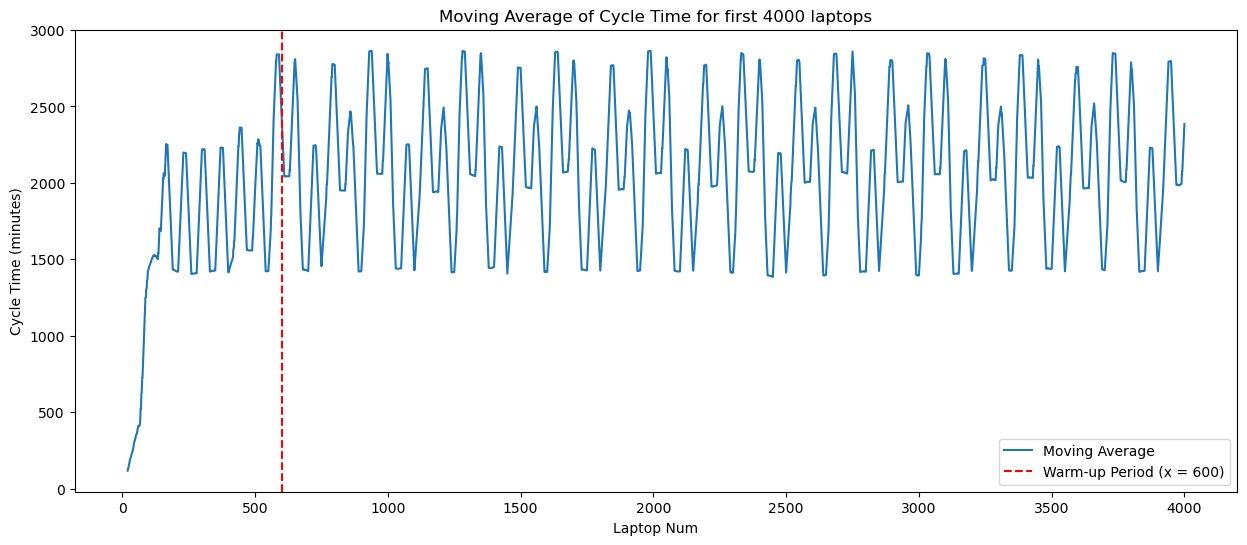

Number of available time windows: 28


In [49]:
warm_up_period = 600
plot_moving_average_cycle_time(laptop_timings_df, 'laptop_num', 'cycle_time', warm_up_period=warm_up_period, y_units='minutes')
time_window = 2 * warm_up_period
laptop_timings_split = []
for i in range(warm_up_period, len(laptop_timings_df), time_window):
    laptop_timings_split.append(laptop_timings_df.iloc[i:i + time_window])
print(f"Number of available time windows: {len(laptop_timings_split)}")

In [50]:
def get_cycle_time_mean(split):
    return split['cycle_time'].mean()

cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))

# Run the m_0 replications
m0 = 5
Y_is = []
for i in range(m0):
    Y_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
Y_bar = sum(Y_is) / m0
s2_m0 = sum([(Y_i - Y_bar) ** 2 for Y_i in Y_is]) / (m0 - 1)
s_m0 = s2_m0 ** 0.5
print(f"Y_bar: {Y_bar:.2f} minutes, s_m0: {s_m0:.2f} minutes")

# Calculate sample eps
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2)
eps = z * s_m0 / m0
print(f"epsilon: {eps:.2f} minutes")

# Calculate the number of replications needed
def get_m(m0, s_m0, eps, alpha):
    n = m0
    while True:
        t = stats.t.ppf(1 - alpha / 2, n - 1)
        s2_n = s_m0 ** 2 * m0 / n
        if n >= (t ** 2 * s2_n) / (eps ** 2):
            break
        n += 1
    return n
m = get_m(m0, s_m0, eps, alpha)
print(f"Number of replications needed: {m}")

X_is = []
for i in range(m):
    X_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
X_bar = sum(X_is) / m
s2_m = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
s_m = s2_m ** 0.5
print(f"X_bar: {X_bar:.2f} minutes, s_m: {s_m:.2f} minutes")
t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
epsilon = t_alpha * s_m / m
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon

print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"The half width of the confidence interval is {epsilon:.2f} minutes")

Y_bar: 2102.00 minutes, s_m0: 11.99 minutes
epsilon: 4.70 minutes
Number of replications needed: 13
X_bar: 2098.83 minutes, s_m: 11.32 minutes
Confidence interval: [2096.93, 2100.73] minutes
The half width of the confidence interval is 1.90 minutes


In [51]:
cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))

desired_precision = 0.01 * Y_bar
m0 = 3
X_is = []
for i in range(m0):
    X_is.append(cycle_time_means.pop(0))

while True:
    m = m0
    X_bar = sum(X_is) / m
    s2 = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
    s = s2 ** 0.5
    t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
    epsilon = t_alpha * s / m
    if epsilon <= desired_precision:
        print(f"Desired precision achieved: {epsilon:.2f} minutes")
        break
    m += 1
    X_is.append(cycle_time_means.pop(0))
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon
print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"Number of replications needed: {m}")

Desired precision achieved: 17.00 minutes
Confidence interval: [2079.37, 2113.37] minutes
Number of replications needed: 3


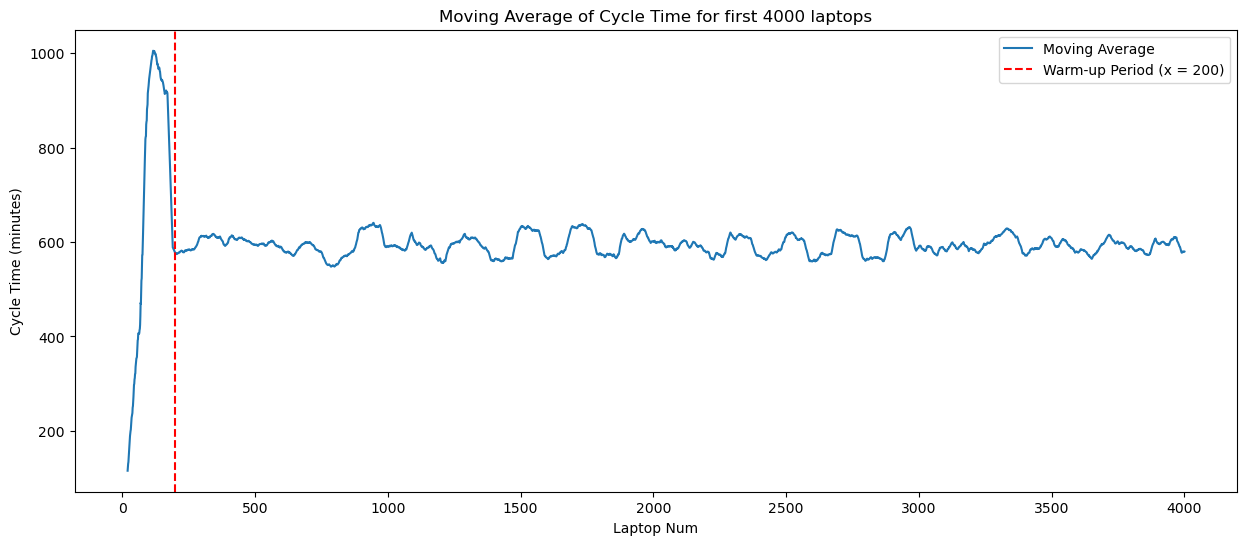

Number of available time windows: 107
Y_bar: 593.23 minutes, s_m0: 0.38 minutes
epsilon: 0.15 minutes
Number of replications needed: 13
X_bar: 594.16 minutes, s_m: 3.05 minutes
Confidence interval: [593.65, 594.67] minutes
The half width of the confidence interval is 0.51 minutes


In [52]:
plot_moving_average_cycle_time(improved_timings_df, 'laptop_num', 'cycle_time', warm_up_period=200, y_units='minutes', filename='moving_average_improved_laptop_num_cycle_time.png')
time_window = 2 * warm_up_period
improved_timings_split = []
for i in range(warm_up_period, len(improved_timings_df), time_window):
    improved_timings_split.append(improved_timings_df.iloc[i:i + time_window])
print(f"Number of available time windows: {len(improved_timings_split)}")
def get_cycle_time_mean(split):
    return split['cycle_time'].mean()
cycle_time_means = list(map(get_cycle_time_mean, improved_timings_split))
# Run the m_0 replications
m0 = 5
Y_is = []
for i in range(m0):
    Y_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
Y_bar = sum(Y_is) / m0
s2_m0 = sum([(Y_i - Y_bar) ** 2 for Y_i in Y_is]) / (m0 - 1)
s_m0 = s2_m0 ** 0.5
print(f"Y_bar: {Y_bar:.2f} minutes, s_m0: {s_m0:.2f} minutes")

# Calculate sample eps
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2)
eps = z * s_m0 / m0
print(f"epsilon: {eps:.2f} minutes")

# Calculate the number of replications needed
def get_m(m0, s_m0, eps, alpha):
    n = m0
    while True:
        t = stats.t.ppf(1 - alpha / 2, n - 1)
        s2_n = s_m0 ** 2 * m0 / n
        if n >= (t ** 2 * s2_n) / (eps ** 2):
            break
        n += 1
    return n
m = get_m(m0, s_m0, eps, alpha)
print(f"Number of replications needed: {m}")

X_is = []
for i in range(m):
    X_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
X_bar = sum(X_is) / m
s2_m = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
s_m = s2_m ** 0.5
print(f"X_bar: {X_bar:.2f} minutes, s_m: {s_m:.2f} minutes")
t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
epsilon = t_alpha * s_m / m
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon

print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"The half width of the confidence interval is {epsilon:.2f} minutes")